In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from tqdm import tqdm
import mmo_utils as ommt
import matplotlib.pyplot as plt
from pyarrow import dataset as ds
import ray

In [2]:
my_runtime_env = {"working_dir": "."}

In [3]:
if ray.is_initialized():
    ray.shutdown()
ray.init(runtime_env=my_runtime_env, ignore_reinit_error=True)


2023-01-15 11:24:21,118	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
2023-01-15 11:24:21,133	INFO packaging.py:546 -- Creating a file package for local directory '.'.
2023-01-15 11:24:21,146	INFO packaging.py:373 -- Pushing file package 'gcs://_ray_pkg_7ce346890b35d236.zip' (0.06MiB) to Ray cluster...
2023-01-15 11:24:21,150	INFO packaging.py:386 -- Successfully pushed file package 'gcs://_ray_pkg_7ce346890b35d236.zip'.


Python version:,3.8.13
Ray version:,2.2.0
Dashboard:,http://127.0.0.1:8266


In [4]:
# Let's read the data as pyarrow table
dataset = ds.dataset(
        "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/",
        partitioning=["year", "month"],
)

In [5]:
# Let's use three sklearn estimator models
models = [LinearRegression(), 
          DecisionTreeRegressor(),
          DecisionTreeRegressor(splitter="random"),
        ]

# Define batch sizes and tracking list 
all_stats_times = []
starting_indexes = [-3, -6, -9]
# starting_indexes = [-3, -6, -9, -12, -15, -18]

In [6]:
for starting_idx in tqdm(starting_indexes):
    files = [f"s3://anonymous@{file}" for file in tqdm(dataset.files)][starting_idx:]
    print(f"Total files obtained {len(files)}")
    results, time_stats = ommt.run_batch_training_with_object_store(files, models=models)
    all_stats_times.append(time_stats)
    print(f"Sample of results: {results[:-1][0]}")
    print("", flush=True)
    print(f"Total number of pickup locations: {time_stats['total_pickup_locations']}")
    print(f"Total number of pickup locations with enough records to train: {time_stats['total_pickup_locations_trained']}")
    print(f"Total number of models trained: {time_stats['total_models_trained']}")
    print(f"TOTAL TIME TAKEN: {time_stats['total_training_time']} seconds")
    print("--" * 10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 257670.55it/s]


Total files obtained 3
Starting optimized run: each task fetching pre-loaded data from Ray object store...
Sample of results: ('s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/04/data.parquet/7e490662e39c4bfe8c64c6a2c45c9e8b_000000.parquet', 239, [(DecisionTreeRegressor(splitter='random'), 439.929), (DecisionTreeRegressor(), 439.93), (LinearRegression(), 612.513)])



 33%|████████████████████████████████████                                                                        | 1/3 [00:37<01:15, 37.75s/it]

Total number of pickup locations: 783
Total number of pickup locations with enough records to train: 783
Total number of models trained: 2349
TOTAL TIME TAKEN: 37.739 seconds
--------------------



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 580749.78it/s]

Total files obtained 6
Starting optimized run: each task fetching pre-loaded data from Ray object store...


Sample of results: ('s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/01/data.parquet/ecce6478ad09480cbc8539e0b6197c2d_000000.parquet', 151, [(DecisionTreeRegressor(), 479.692), (DecisionTreeRegressor(splitter='random'), 479.713), (LinearRegression(), 639.633)])



 67%|████████████████████████████████████████████████████████████████████████                                    | 2/3 [01:46<00:55, 55.83s/it]

Total number of pickup locations: 1568
Total number of pickup locations with enough records to train: 1568
Total number of models trained: 4704
TOTAL TIME TAKEN: 68.477 seconds
--------------------



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 43364.43it/s]

Total files obtained 9
Starting optimized run: each task fetching pre-loaded data from Ray object store...



(raylet) Spilled 2194 MiB, 941 objects, write throughput 713 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


Sample of results: ('s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/10/data.parquet/20624e28db574114b47de3e43065f014_000000.parquet', 68, [(DecisionTreeRegressor(splitter='random'), 589.14), (DecisionTreeRegressor(), 589.186), (LinearRegression(), 740.233)])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:35<00:00, 71.87s/it]

Total number of pickup locations: 2355
Total number of pickup locations with enough records to train: 2355
Total number of models trained: 7065
TOTAL TIME TAKEN: 109.322 seconds
--------------------


In [8]:
#  Print all cumulative results and stats
all_stats_times_df = pd.DataFrame(all_stats_times, index=[3, 6, 9])
# all_stats_times_df = pd.DataFrame(all_stats_times, index=[3, 6, 9, 12, 15, 18])
display(all_stats_times_df)

,total_pickup_locations,total_pickup_locations_trained,total_models_trained,total_training_time
3,783,783,2349,37.739
6,1568,1568,4704,68.477
9,2355,2355,7065,109.322


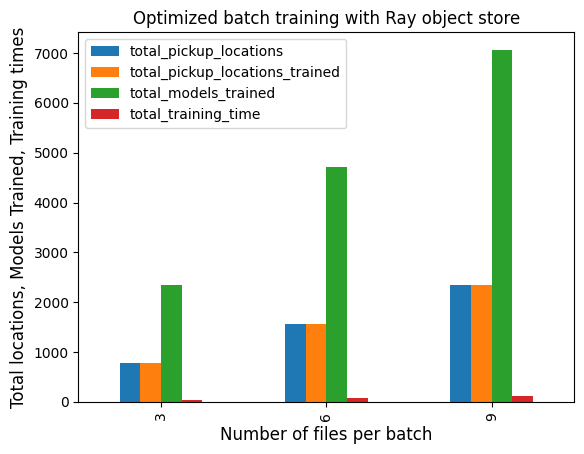

In [10]:
# Plot some times
all_stats_times_df.plot(kind="bar")

plt.ylabel("Total locations, Models Trained, Training times", fontsize=12)
plt.xlabel("Number of files per batch", fontsize=12)
plt.title("Optimized batch training with Ray object store")

plt.grid(False)
plt.show()